In [ ]:
# ..... getting best-matched clusters from MN ..... #

In [2]:
library(igraph)

# get consensus clusters
integrate_outliers <- function(cluster1, outl, fullmatall, n){
    cluster2 = cluster1
    
    for(ii in 1:length(outl)){
        curroutl = outl[ii]
        id1 = match(curroutl, colnames(fullmatall))
        list1 = sort(fullmatall[,id1], decreasing = T)[1:n]  # get top 10 incl itself    

        tout1 = table(cluster1$cluster[match(names(list1), cluster1$metacell)])
        
        if(tout1[which.max(tout1)]>=3){
#             print(paste0(curroutl, ' : ', names(tout1)[which.max(tout1)]))
            temp = data.frame(metacell = curroutl,
                              cluster = names(tout1)[which.max(tout1)][1],
                             map_type = paste0('majority_top_', n))
            cluster2 = rbind(cluster2, temp)
        }
    }
    return(cluster2)
}

In [3]:
stage1 = 'stage28'
load(paste0(stage1, '_monocle_cluster_MN_scores.Rdata'))

In [4]:
top_1v1$type = '1vbest'
top_all$type = 'allvall'
df = rbind(top_1v1, top_all)

In [30]:
# write.table(df, file = paste0(stage1, '_combined_MN.csv'), sep = ',', row.names = F, col.names = T, quote = F)

In [5]:
# manual tweaking to split similar clusters
rmid = which(df[,1] == 'sample11|8' & df[,2] == 'sample5|9')  # stage 28
# rmid = which(df[,1] == 'sample5|10' & df[,2] == 'sample12|16')  # stage 32
df = df[-rmid,]

[1] 3 3 3 3 4 3 5 3 4 4 2 2

[1] 12

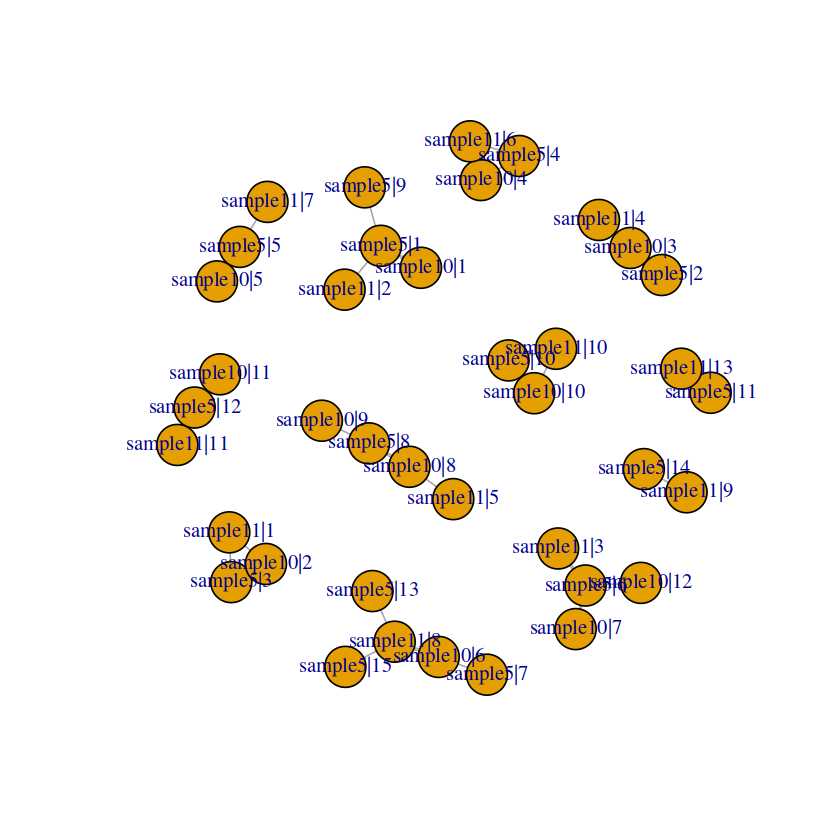

In [6]:
# initial graph from topdf
g <- graph.data.frame(df, directed=FALSE)
plot(g)
components(g)$csize
components(g)$no

In [7]:
# get initial matchign of metacells
newdf = data.frame(metacell = names(components(g)$membership), 
                   cluster = paste0('cluster_', components(g)$membership))
newdf$map_type = 'Reciprocal_auroc_0.85'
rownames(newdf) = NULL
head(newdf)

metacell    cluster   map_type             
1 sample5|10  cluster_1 Reciprocal_auroc_0.85
2 sample5|12  cluster_2 Reciprocal_auroc_0.85
3 sample10|10 cluster_1 Reciprocal_auroc_0.85
4 sample5|3   cluster_3 Reciprocal_auroc_0.85
5 sample10|3  cluster_4 Reciprocal_auroc_0.85
6 sample5|6   cluster_5 Reciprocal_auroc_0.85

In [8]:
ctypes = newdf$metacell
alltypes = rownames(aurocsall)
outliers_all = setdiff(alltypes, ctypes)
length(ctypes)
length(alltypes)
length(outliers_all)

[1] 39

[1] 40

[1] 1

In [9]:
# round 'n', do upto as many rounds and see when converges
# iterative procedure to update cross_sample metacell mapping

# clusters tend to group with already dense cross-species clusters, rather than with
# smaller clusters (with fewer clusters and/or species)
topn = c(10, 10, 10, 20, 20, 20)
for(numround in 1:6){
    
    ctypes = newdf$metacell
    outliers = setdiff(alltypes, ctypes)
    
    if(length(outliers)){
        newdf = integrate_outliers(newdf, outliers, aurocsall, topn[numround])

        print(paste0(numround, ' : ', length(outliers), '  ', 
                     length(alltypes) - dim(newdf)[1]))                     
    }
}

[1] "1 : 1  0"


[1] 3 4 3 3 4 3 5 3 4 4 2 2

[1] 12

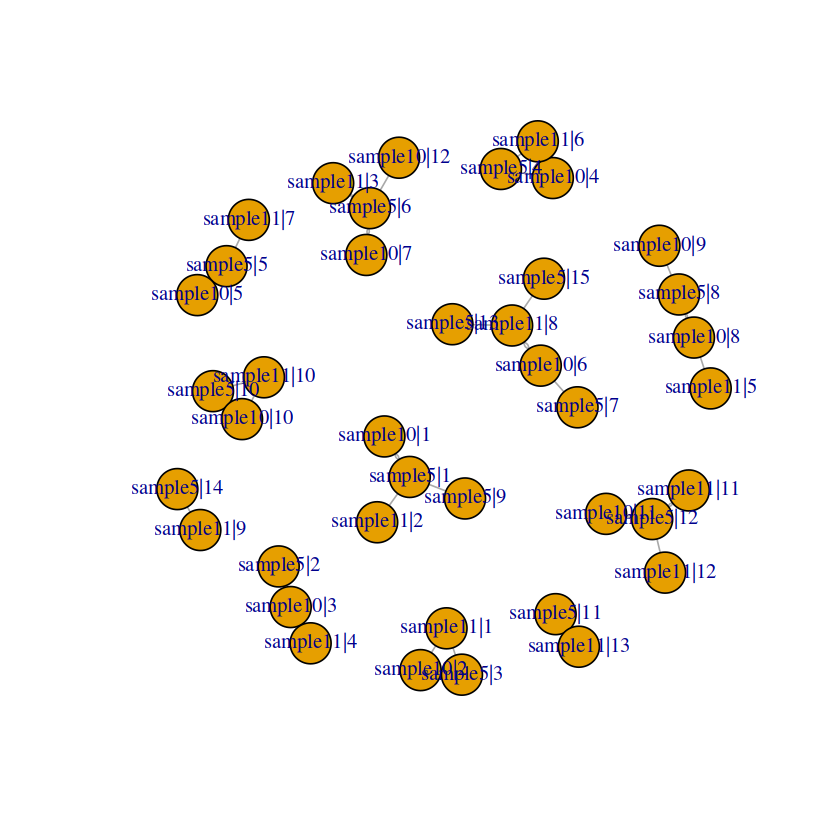

In [10]:
# final graph from topdf
match_all = newdf$metacell[match(newdf$cluster[match(outliers_all, newdf$metacell)], newdf$cluster)]
temp = data.frame(outliers_all, match_all, rep(NA, length(outliers_all)), 
                  rep('majority_topN', length(outliers_all)), rep('manual', length(outliers_all)))
colnames(temp) = colnames(df)

topdf2 = rbind(df, temp)
g2 <- graph.data.frame(topdf2, directed=FALSE)
plot(g2)
components(g2)$csize
components(g2)$no

In [11]:
newdf$stage = stage1
newdf$sample = sub('\\|.*', '', newdf$metacell)
newdf$monocle_cls = sub('.*\\|', '', newdf$metacell)
dim(newdf)
length(unique(newdf$cluster))
newdf[1,]

[1] 40  6

[1] 12

metacell   cluster   map_type              stage   sample  monocle_cls
1 sample5|10 cluster_1 Reciprocal_auroc_0.85 stage28 sample5 10

In [84]:
write.table(newdf, file = paste0(stage1, '_monocle_matched_clusters.csv'), sep = ',', 
            row.names = F, col.names = T, quote = F)

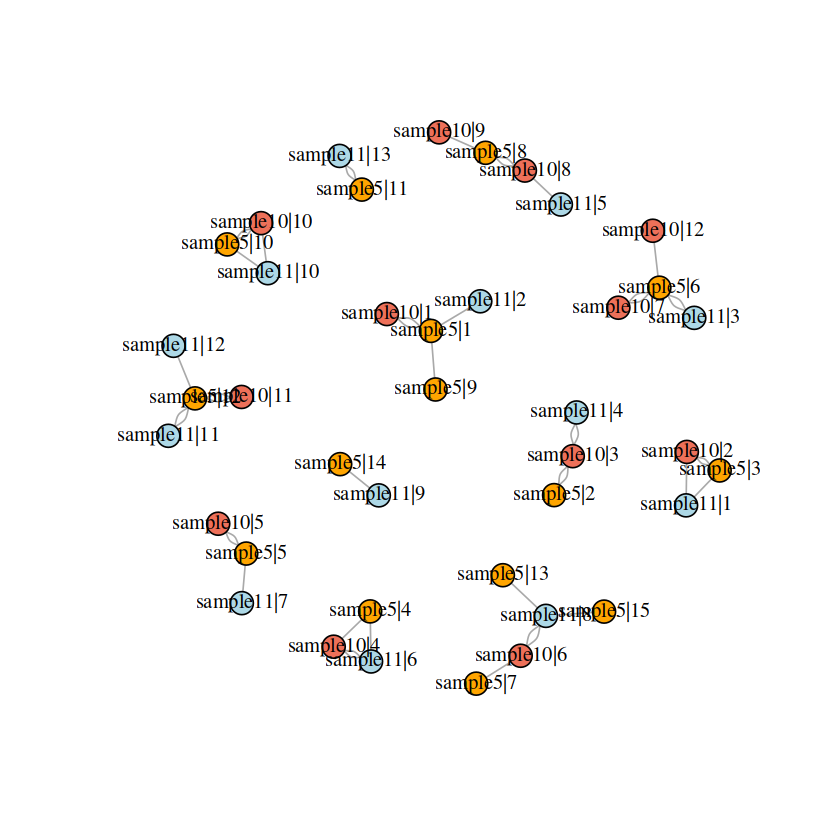

In [15]:
answers = data.frame(celltype = ctypes, sample = sub('\\|.*', '', ctypes), color = 'orange')
smp = unique(answers$sample)
answers$color[answers$sample==smp[2]] = '#ed7059'
answers$color[answers$sample==smp[3]] = 'lightblue'

g2 <- graph.data.frame(topdf2, vertices = answers, directed=FALSE)

# visualize final clustering
# pdf(paste0('aa-', stage1, '-graph.pdf'), width = 20, height = 20)
# png(paste0('aa-', stage1,'-graph.png'), width = 5, height = 5, res = 300, units = 'in')
plot(g2, vertex.size = 8, vertex.label.color = 'black', label.degree = 'pi/2')
# dev.off()